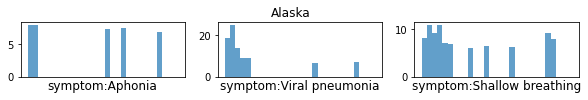

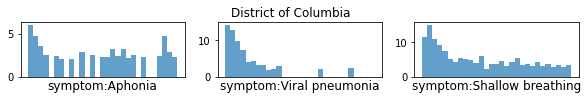

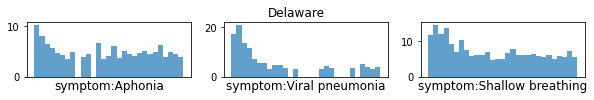

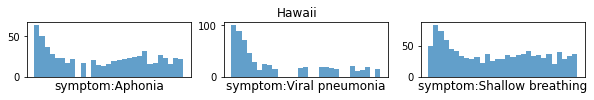

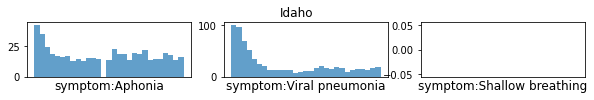

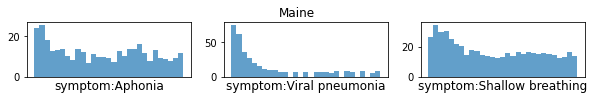

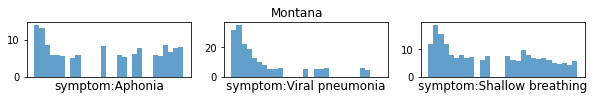

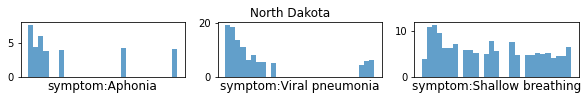

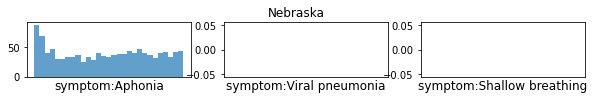

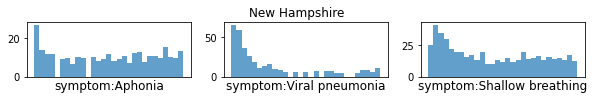

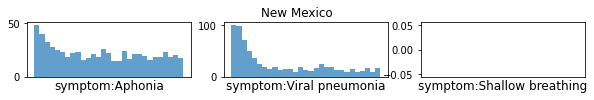

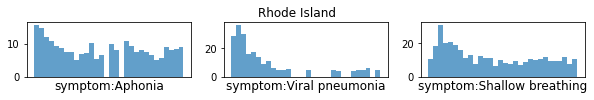

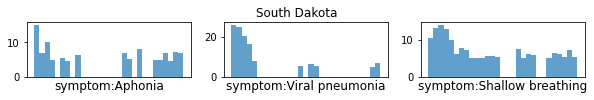

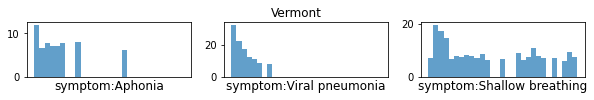

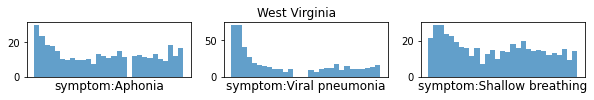

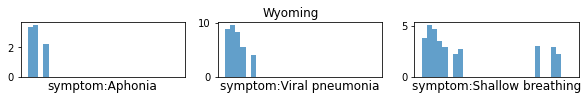

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


df = pd.read_csv('result.csv')
df.iloc[:, 3:] = df.iloc[:, 3:].apply(pd.to_numeric)
df = df.fillna(0)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
symptoms = pd.DataFrame(df[df.columns[3:-1]].sum(axis=0), columns=['sum']).\
    sort_values(by=['sum'], ascending=False).head(15).index.values
regions = df.region_name.unique()
data = df.iloc[:, 3:-1]

data_copy = data
for region in regions:
    plt.figure(figsize=(10,1))
    plt.figure(1)
    data_copy = df.loc[df['region_name'] == region][np.append(symptoms, 'date')]
    for i in range(1,4):
        ax = plt.subplot(1,3,i)
        ax.bar(data_copy.date, data_copy.iloc[:, i-1], alpha=0.7, width=7)
        ax.set_title(symptoms[i-1], y=-0.35)
        ax.set_xticks([])
    plt.suptitle(region, y=1.1)
    plt.show()

We will use PCA for Dimensionality Reduction, since there is an implementation provided by `sci-kit learn`, we will use that package to perform the task

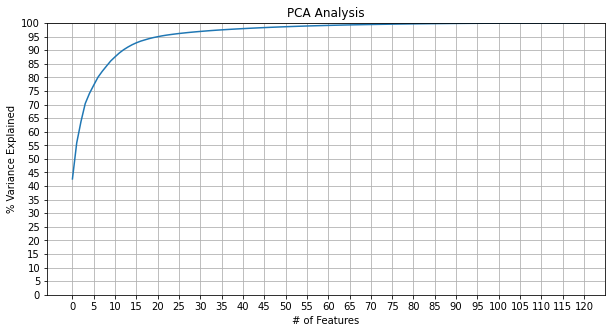

In [2]:
pca = PCA(n_components=120)
pca.fit(data)
variance = pca.explained_variance_ratio_
var = np.cumsum(variance*100)
plt.figure(figsize=(10,5))
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(0,100)
x = range(0,121,5)
y = range(0,101,5)
plt.grid()
plt.plot(var)   
plt.yticks(y)
plt.xticks(x)
plt.show()

Thus, we found that by using 20 features, we have 95% variance explained

Text(0.5, 1.0, 'Variance Explained vs Principal Components')

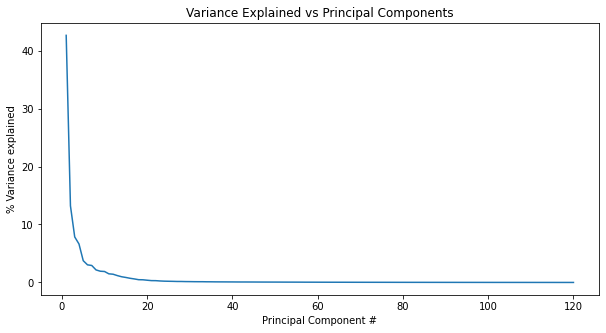

In [3]:
pca2 = PCA()
pca2.fit(data)
num_pc_components = len(pca2.explained_variance_ratio_)
plt.figure(figsize=(10,5))
plt.plot(np.linspace(1,num_pc_components,num_pc_components),100*pca2.explained_variance_ratio_)
plt.xlabel("Principal Component #")
plt.ylabel("% Variance explained")
plt.title("Variance Explained vs Principal Components")


Text(0.5, 1.0, 'Cumulative Variance Explained vs Principal Components')

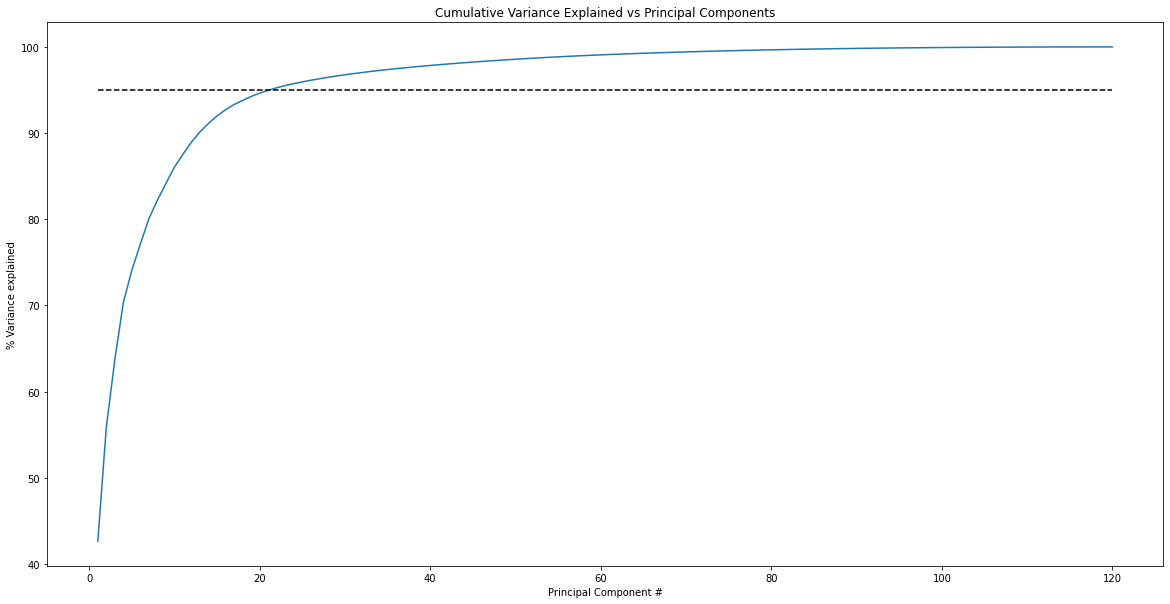

In [4]:
plt.figure(figsize=(20,10))
plt.plot(np.linspace(1,num_pc_components,num_pc_components),100*np.cumsum(pca2.explained_variance_ratio_))
plt.plot(np.linspace(1,num_pc_components,num_pc_components),95*np.ones((num_pc_components,)),'k--')
plt.xlabel("Principal Component #")
plt.ylabel("% Variance explained")
plt.title("Cumulative Variance Explained vs Principal Components")

### Visualize PCA Reduced low-dimensional data

Text(0, 0.5, 'PC #2')

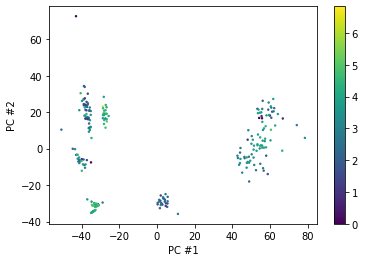

In [5]:
pca = PCA(n_components=20)
pca.fit(data)
X_reduced = pca.transform(data)
cmap = sns.cubehelix_palette(as_cmap=True)

plt.scatter(X_reduced[:,0], X_reduced[:,1], c=np.log(df.iloc[:,-1]),s=2)
plt.colorbar()
plt.xlabel("PC #1")
plt.ylabel("PC #2")

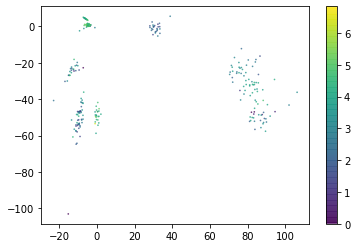

In [6]:
data = df.iloc[:, 3:-1]
u, s, vt = np.linalg.svd(data-np.mean(data,0))
pcs = data @ vt.T
cmap = sns.cubehelix_palette(as_cmap=True)

plt.scatter(pcs.iloc[:,0], pcs.iloc[:,1], c=np.log(df.iloc[:,-1]), s=.5, alpha=.7)
plt.colorbar()
plt.show()

converged after 4 iterations, cost 866833.0292575284


Text(0.5, 1.0, 'class labels')

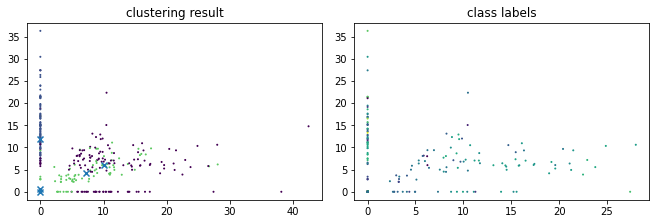

In [7]:
class KMeans:
    def __init__(self, k=5, max_iters=100, verbose=True):
        self.k = k
        self.max_iters = max_iters
        self.verbose = verbose

    def fit(self, x):
        n,d = x.shape
        init_centers = np.random.choice(n, self.k, replace=False)
        mu = x[init_centers, :]
        for t in range(self.max_iters):
            distances = np.sum((mu[None,:,:] - x[:,None,:])**2, -1) # n x k
            membership = np.argmin(distances, 1)
            mu_new = mu.copy()
            for i in range(self.k):
                mu_new[i,:] = np.mean(x[membership==i], 0)
            if np.allclose(mu_new, mu):
                if self.verbose:
                    print(f'converged after {t} iterations, cost {np.sum(np.min(distances,1))}')
                break
            mu = mu_new
        return mu, membership

x, y = data.values, df.iloc[:, -1]
kmeans = KMeans(5)
mu, cl = kmeans.fit(x)
fig, axes = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(9, 3))
axes[0].scatter(x[:,0], x[:,1], c=cl, s=1)
axes[0].scatter(mu[:,0], mu[:,1], marker='x')
axes[0].set_title('clustering result')
axes[1].scatter(x[:,0], x[:,1], c=np.log(y), s=1)
axes[1].set_title('class labels')